In [1]:
import math
import numpy as np
import glob
import seaborn as sns
from matplotlib import pyplot as plt
#%matplotlib inline

/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## README: Formatting origin-destination tsv files as BEAST GLM linearized matrices

Once linearized, the 1D predictor matrix should be length_matrix times length_matrix - 1 long. This is because the diagonal values (eg canada to canada) are removed from the linearized matrix before it is put in the xml. Thus, if you have 45 countries in your GLM, then the linearized matrix should be 45 * 44 entries long. 

Note that indexing for GLM matrices in BEAST is also a little different. All entries to the top of the diagonal are sequentially filled in first, row by row. Then cell entries on the bottom of the matrix are filled in, column by column.

XXXXXXX| usa |canada| mexico
-------|-----|-------|-------
usa    |XXXXX|  0    | 1
canada |3    |XXXXXXX| 2
mexico |4    |  5    | XXXXXX

When linearized for the xml, the above predictor matrix takes the form of `[0, 1, 2, 3, 4, 5]`.

If we have a dictionary, where the index is the key, and the value is a tuple, in form `(origin, destination)`, then the dictionary should look like this:

`{0: ('usa', 'canada'), 1: ('usa', 'mexico'), 2: ('canada', 'mexico'), 3: ('canada', 'usa'), 4: ('mexico', 'usa'), 5: ('mexico', 'canada')}`


In [2]:
# specify functions

def logMatrix(matrix):
    logged_matrix = [np.log(value) for value in matrix]
    return logged_matrix

def standardizeMatrix(matrix):
    mean = np.nanmean(matrix)
    stdev = np.nanstd(matrix)
    standardized_matrix = [(value - mean)/stdev for value in matrix if value != float('nan')] #if value is nan, then will be in std matrix as nan too
    return standardized_matrix

def make_GLMmatrix(predictor_dict,predictor_name_string,lnTransform=True):
    linearized_predictor = []
    for i in range(len(predictor_dict)):
        try: 
            linearized_predictor.append(predictor_dict[i][predictor_name_string])
        except KeyError:
            linearized_predictor.append(float('nan')) #allows missing data for countries without pax volume
    if lnTransform == True:
        logged_matrix = logMatrix(linearized_predictor)
        GLM_matrix = standardizeMatrix(logged_matrix)
    elif lnTransform == False:
        GLM_matrix = standardizeMatrix(linearized_predictor)
    return GLM_matrix


### Initially try everything out on a test dataset.

I've made a little test tsv file, and have a small list of three countries that I want to set up predictors for. Just making sure here that everything is working the way I think it should on a dataset that's small enough that I can spot errors easily.

In [3]:
# code to make the indexing dictionaries, adapted from Gytis Dudas' EBOV iPython notebook.
# nothing crazy, just math to deal with the funky GLM indexing.
test_countries = ['united_states','canada','mexico']
test_predictor_dict={}
matrix_length=len(test_countries)

for i in range(len(test_countries)):
    for j in range(i+1,len(test_countries)): #make the second iteration 1 shorter than the first
        index_1=int((matrix_length*(matrix_length-1)/2) - (matrix_length-i)*((matrix_length-i)-1)/2 + j - i - 1)
        index_2=int((matrix_length*(matrix_length-1)) - (matrix_length-i)*((matrix_length-i)-1)/2 + j - i - 1)

        test_predictor_dict[index_1] = {'country_pair':(test_countries[i],test_countries[j])}
        test_predictor_dict[index_2] = {'country_pair':(test_countries[j],test_countries[i])}

print test_predictor_dict

{0: {'country_pair': ('united_states', 'canada')}, 1: {'country_pair': ('united_states', 'mexico')}, 2: {'country_pair': ('canada', 'mexico')}, 3: {'country_pair': ('canada', 'united_states')}, 4: {'country_pair': ('mexico', 'united_states')}, 5: {'country_pair': ('mexico', 'canada')}}


In [4]:
# try importing test predictor set, and assigning great circle distances

test_infile = '/Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/origin-destin-formatted-data/origin-destination-TEST.tsv'
with open(test_infile,'rU') as file:
    for line in file:
        if line.startswith('origin'): # this line is the header of the tsv
            predictor  = line.strip().split('\t')[2] #predictor name in the tsv is what it will be called in dict
        else:
            country_tuple = (line.split('\t')[0],line.split('\t')[1]) # origin,destination tuple
            for key in test_predictor_dict.keys():
                if test_predictor_dict[key]['country_pair'] == country_tuple:
                    test_predictor_dict[key][predictor] = float(line.strip().split('\t')[2])
print test_predictor_dict

{0: {'country_pair': ('united_states', 'canada'), 'great_circle_dist_km': 1077.10699074}, 1: {'country_pair': ('united_states', 'mexico'), 'great_circle_dist_km': 1922.06469662}, 2: {'country_pair': ('canada', 'mexico'), 'great_circle_dist_km': 2997.40071085}, 3: {'country_pair': ('canada', 'united_states'), 'great_circle_dist_km': 1077.10699074}, 4: {'country_pair': ('mexico', 'united_states'), 'great_circle_dist_km': 1922.06469662}, 5: {'country_pair': ('mexico', 'canada'), 'great_circle_dist_km': 2997.40071085}}


In [5]:
# CHECK TO MAKE SURE EVERYTHING IS WORKING RIGHT!!! Should match up with indexing of markdown table above.
test_linearized_predictor = []

for i in range(len(test_predictor_dict)):
    print test_predictor_dict[i]['country_pair']
    test_linearized_predictor.append(test_predictor_dict[i]['great_circle_dist_km'])

print test_linearized_predictor

('united_states', 'canada')
('united_states', 'mexico')
('canada', 'mexico')
('canada', 'united_states')
('mexico', 'united_states')
('mexico', 'canada')
[1077.10699074, 1922.06469662, 2997.40071085, 1077.10699074, 1922.06469662, 2997.40071085]


In [6]:
#try out log transforming matrix
testLog_predictor = logMatrix(test_linearized_predictor)
print testLog_predictor #yes, this looks right
print np.mean(testLog_predictor)
print np.std(testLog_predictor)

[6.9820340136708214, 7.5611552500563279, 8.0055007623664025, 6.9820340136708214, 7.5611552500563279, 8.0055007623664025]
7.5162300087
0.41903440941


In [7]:
test_std = std_matrix = standardizeMatrix(testLog_predictor)
double_check_std = [(value-np.mean(testLog_predictor))/np.std(testLog_predictor) for value in testLog_predictor]
print test_std
print double_check_std
assert test_std == double_check_std, 'something wrong with standardization code'

[-1.2748260835639709, 0.10721134195567286, 1.1676147416082978, -1.2748260835639709, 0.10721134195567286, 1.1676147416082978]
[-1.2748260835639709, 0.10721134195567286, 1.1676147416082978, -1.2748260835639709, 0.10721134195567286, 1.1676147416082978]


In [8]:
#test that function that includes logging and standardizing does the same thing:
lntransformed_test_matrix = make_GLMmatrix(test_predictor_dict,'great_circle_dist_km',lnTransform=True)
no_lntransform_test_matrix = make_GLMmatrix(test_predictor_dict,'great_circle_dist_km',lnTransform=False)

print test_std
print lntransformed_test_matrix #should match test_std with is logged then standardized.
print no_lntransform_test_matrix #should be different, only standardized, no logging.

raw_mean = np.mean(test_linearized_predictor)
raw_std = np.std(test_linearized_predictor)
double_check_std_noLog = double_check_std = [(value-raw_mean)/raw_std for value in test_linearized_predictor]
print double_check_std_noLog

[-1.2748260835639709, 0.10721134195567286, 1.1676147416082978, -1.2748260835639709, 0.10721134195567286, 1.1676147416082978]
[-1.2748260835639709, 0.10721134195567286, 1.1676147416082978, -1.2748260835639709, 0.10721134195567286, 1.1676147416082978]
[-1.1729568426582233, -0.097721245395403278, 1.2706780880536279, -1.1729568426582233, -0.097721245395403278, 1.2706780880536279]
[-1.1729568426582233, -0.097721245395403278, 1.2706780880536279, -1.1729568426582233, -0.097721245395403278, 1.2706780880536279]


Test out writing the predictor matrices to file as they'll need to be formatted for BEAST xml.

In [15]:
test_outfile = '/Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/transformed-linearized-matrices/test-matrix.txt'
xml_template ='''\n<!-- predictor: {long_form_name} -->\n<parameter id="{short_form_name}" value="{values}"/>\n'''

test_predictor = xml_template.format(long_form_name='Test predictor matrix, great circle dists',short_form_name='test_predictor', values = ' '.join(str(value) for value in lntransformed_test_matrix))
with open(test_outfile,'w') as file:
    file.write(test_predictor)
    file.write(test_predictor)

### Testing looks good. Now we'll do it for the full set of 45 countries to include in the GLM. 

1) Import from indexed-countries-45.tsv to get the full list of countries that will be used.
2) Start by importing all countryXcountry great circle distances.

In [9]:
with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/indexed-countries-45.tsv') as file:
    countries_list = [line.strip().split('\t')[0] for line in file if not line.startswith('country')]
    
print countries_list #this should be ordered north to south

print '\n {} countries included in analysis'.format(len(countries_list)) #this should be 45

['canada', 'united_states', 'bermuda', 'mexico', 'belize', 'guatemala', 'honduras', 'el_salvador', 'nicaragua', 'costa_rica', 'panama', 'bahamas', 'cuba', 'turks_caicos_islands', 'cayman_islands', 'jamaica', 'haiti', 'dominican_republic', 'puerto_rico', 'united_states_virgin_islands', 'saint_kitts_nevis', 'antigua_barbuda', 'guadeloupe', 'dominica', 'martinique', 'saint_lucia', 'saint_vincent_grenadines', 'barbados', 'grenada', 'trinidad_tobago', 'curacao', 'aruba', 'french_guiana', 'suriname', 'guyana', 'venezuela', 'colombia', 'ecuador', 'peru', 'bolivia', 'brazil', 'paraguay', 'uruguay', 'argentina', 'chile']

 45 countries included in analysis


In [10]:
#make predictor dictionary. Index is key, value is dict with origin,destination tuple.

predictor_dict = {}

matrix_length=len(countries_list)

for i in range(len(countries_list)):
    for j in range(i+1,len(countries_list)): #make the second iteration 1 shorter than the first
        index_1=int((matrix_length*(matrix_length-1)/2) - (matrix_length-i)*((matrix_length-i)-1)/2 + j - i - 1)
        index_2=int((matrix_length*(matrix_length-1)) - (matrix_length-i)*((matrix_length-i)-1)/2 + j - i - 1)

        predictor_dict[index_1] = {'country_pair':(countries_list[i],countries_list[j])}
        predictor_dict[index_2] = {'country_pair':(countries_list[j],countries_list[i])}

assert len(predictor_dict) == len(countries_list)**2 - len(countries_list), 'predictor dictionary malformed'

#### As a reference, I'm going to write the index for each country pair to a tsv file.

In [11]:
with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/index-countrypair-mapping.tsv','w') as file:
    file.write('{}\t{}\n'.format('index', 'country_pair'))
    for i in range(len(predictor_dict)):
        file.write('{}\t{}\n'.format(i, predictor_dict[i]['country_pair']))

## Add predictor values to the dictionary based on key matching of the country pair tuple.

Using glob I'm going to loop through all the predictor files that I have in my `origin-destination` directory, and import them into the predictors dictionary.

In [12]:
input_dir = "/Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/origin-destin-formatted-data/*.tsv"

for fname in glob.glob(input_dir):
    #skip testing tsv
    if fname == '/Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/origin-destin-formatted-data/origin-destination-TEST.tsv':
        continue
    else:
        with open(fname,'rU') as file:
            print 'importing predictor from {}'.format(fname)
            for line in file:
                if line.startswith('origin'): # this line is the header of the tsv
                    predictor  = line.strip().split('\t')[2] #predictor name in the tsv is what it will be called in dict
                else:
                    country_tuple = (line.split('\t')[0],line.split('\t')[1]) # origin,destination tuple
                    for key in predictor_dict.keys(): #iterate through the indices
                        if predictor_dict[key]['country_pair'] == country_tuple:
                            predictor_dict[key][predictor] = float(line.strip().split('\t')[2])
print 'finished'

importing predictor from /Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/origin-destin-formatted-data/destination-population-size.tsv
importing predictor from /Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/origin-destin-formatted-data/destination-suitability.tsv
importing predictor from /Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/origin-destin-formatted-data/destination-urban-proportion.tsv
importing predictor from /Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/origin-destin-formatted-data/origin-destin-great-circle-dists.tsv
importing predictor from /Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/origin-destin-formatted-data/origin-destin-north-south-indicator.tsv
importing predictor from /Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/origin-destin-formatted-data/origin-destin-pax-volume.tsv
importing predictor from /Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/origin-destin-formatted-data/origin-population-size.tsv
importing predictor from /Users/alliblk

## Deal with countries with no passenger air travel between them

For the passenger volume data, if there was no volume between two locations, there was no entry in the original tsv file. However, because the indexing is important for the GLM, I need all country pairs to have some value of air traffic between them. Therefore, I'm going to make the `pax_volume` value equal `0` if `PAXvolume` does not exist for a country pair (doing this by leveraging a `KeyError`).

To keep tabs on things while I do this I'm also going to write country pairs without pax volume to a file.

In [13]:
# make note of which country pairs do not have any travel between them, and their indices!

with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/countries-without-pax-volume.tsv','w') as file:
    file.write('{}\t{}\n'.format('index', 'country_pair_without_pax_volume'))
    for i in range(len(predictor_dict)):
        try:
            predictor_dict[i]['pax_volume']
        except KeyError: #make pax volume = 0 if there's no record of pax volume between two countries from the input data file
            file.write('{}\t{}\n'.format(i, predictor_dict[i]['country_pair']))
            predictor_dict[i]['pax_volume'] = 0.0

While we now have the total number of passengers traveling between countries (`pax_volume`) what we actually want is the amount of air traffic _per capita_ between two countries. We want this predictor to represent the probability that a sick person in country X gets on a plane and travels to country Y. Thus, we need the per capita rate at which people from country X fly to country Y, not just the total number of individuals that flew. To get this quantity, we take the pax_volume value and divide it by the population size at the origin country.

I'm not ln-transforming these values because there are so many values that are very close to 0 (e.g. 0.0001). With the ln-transform we are aiming to get a distribution that is roughly normal around 0, ranging for -2 to 2. If we ln-transform such small values, we would end up with values are that are more extreme than we get without the ln transform. (e.g., currently the highest per capita pax volume is from puerto rico to united states, at 7.14, but there's a variety of pairs that have a per capita travel rate of less than 0.0005, and if we ln-transform that the value would be -7.6. 

In [25]:
for i in range(len(predictor_dict)):
    predictor_dict[i]['per_capita_pax_volume'] = predictor_dict[i]['pax_volume']/predictor_dict[i]['origin_population_size']

In [35]:
#some countries have per capita pax volumes greater than one. This seems to happen primarily with small
#nations as the origin with large countries as the destination
#these all seem reasonable given geographic and social ties between countries.
for i in range(len(predictor_dict)):
    if predictor_dict[i]['per_capita_pax_volume'] > 1:
        #print i
        print predictor_dict[i]['per_capita_pax_volume']
        print predictor_dict[i]['country_pair']

2.26378561501
('aruba', 'venezuela')
4.20925999097
('bermuda', 'united_states')
3.95482563002
('bahamas', 'united_states')
7.09899182043
('turks_caicos_islands', 'united_states')
6.88836604439
('cayman_islands', 'united_states')
1.09752412639
('puerto_rico', 'united_states')
7.1480777119
('united_states_virgin_islands', 'united_states')
1.38933889785
('saint_kitts_nevis', 'united_states')
1.41292713051
('antigua_barbuda', 'united_states')
1.09037298326
('saint_lucia', 'united_states')
6.01014593468
('aruba', 'united_states')


### Make GLM matrices (ln-transform[optional] and standardize)

In [37]:
print min([predictor_dict[i]['per_capita_pax_volume'] for i in range(len(predictor_dict))])
print np.mean([predictor_dict[i]['per_capita_pax_volume'] for i in range(len(predictor_dict))])

0.0
0.0354840688327


In [38]:
for i in range(len(predictor_dict)):
    if predictor_dict[i]['per_capita_pax_volume'] < 0.05:
        #print i
        print predictor_dict[i]['per_capita_pax_volume']
        print predictor_dict[i]['country_pair']

0.00119224066688
('canada', 'bermuda')
0.0490843730912
('canada', 'mexico')
0.000298368950092
('canada', 'belize')
0.000817012728612
('canada', 'guatemala')
0.000207811208724
('canada', 'honduras')
0.000586183123136
('canada', 'el_salvador')
0.000631770777191
('canada', 'nicaragua')
0.00404009355575
('canada', 'costa_rica')
0.000931739786569
('canada', 'panama')
0.00329845204089
('canada', 'bahamas')
0.0337743321296
('canada', 'cuba')
0.00127659466961
('canada', 'turks_caicos_islands')
0.000689457125148
('canada', 'cayman_islands')
0.0109863158438
('canada', 'jamaica')
0.00108705782221
('canada', 'haiti')
0.0191153749416
('canada', 'dominican_republic')
0.00144123234882
('canada', 'puerto_rico')
0.000247195124142
('canada', 'united_states_virgin_islands')
0.000154391685531
('canada', 'saint_kitts_nevis')
0.000622675703352
('canada', 'antigua_barbuda')
0.000417054049441
('canada', 'guadeloupe')
5.51037961266e-05
('canada', 'dominica')
0.00034412503144
('canada', 'martinique')
0.00106673

In [39]:
gcd_transformed = make_GLMmatrix(predictor_dict,'great_circle_dist_km',lnTransform=True)

originPopSz_transformed = make_GLMmatrix(predictor_dict,'origin_population_size',lnTransform=True)
destinPopSz_transformed = make_GLMmatrix(predictor_dict,'destination_population_size',lnTransform=True)

#Do not ln-transform because values are 0 to 1, still standardize
originPropUrban_transformed = make_GLMmatrix(predictor_dict,'origin_urban_proportion',lnTransform=False)
destinPropUrban_transformed = make_GLMmatrix(predictor_dict,'destination_urban_proportion',lnTransform=False)

#Do not ln-transform because values are 0 to 1, still standardize
originSuitability_transformed = make_GLMmatrix(predictor_dict,'origin_zika_suitability',lnTransform=False)
destinSuitability_transformed = make_GLMmatrix(predictor_dict,'destination_zika_suitability',lnTransform=False)

#Do not ln-transform, but do standardize per capita pax volume:
per_capita_pax_transformed = make_GLMmatrix(predictor_dict,'per_capita_pax_volume',lnTransform=False)


## I'm dealing with the North-South indicator predictors a little bit differently, so I'm making the standardized matrix outside of my functions, below.

1) The North-South indicator does not need to be standardized.

The north-south indicator is perfectly symmetrical with values 1 and -1. This means that the mean of the matrix is 0, and the standard deviation is 1. Therefore, standardizing the matrix [(value - mean)/stdev] == value - 0/1. Thus the standardized matrix is exactly the same as the input matrix.

A bit of testing showing this is below.

In [40]:
#non-standardized matrix, is exactly the same as the input matrix (values untransformed from what's in dict)
north_south_linearized_predictor = []
for i in range(len(predictor_dict)):
    north_south_linearized_predictor.append(predictor_dict[i]['north_south_indicator'])

#standardized matrix, if I were to use my GLM matrix function, although not lnTransforming (not necessary, already on right scale)
north_south_transformed = make_GLMmatrix(predictor_dict,'north_south_indicator',lnTransform=False)

assert north_south_linearized_predictor == north_south_transformed, 'input matrix and standardized matrix differ, check for code errors'

Print out predictors to file in correct format for BEAST.

In [41]:
predictors_outfile = '/Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/transformed-linearized-matrices/xml-formatted-predictors.txt'
xml_template ='''\n<!-- predictor: {long_form_name} -->\n<parameter id="{short_form_name}" value="{values}"/>\n'''

gcd_predictor = xml_template.format(long_form_name='Great circle distances between population-weighted centroids, ln-transformed, standardized',short_form_name='great_circle_distances', values = ' '.join(str(value) for value in gcd_transformed))
pax_predictor = xml_template.format(long_form_name='Per capita air traffic passenger volume between countries, standardized',short_form_name='per_capita_pax_volume', values = ' '.join(str(value) for value in per_capita_pax_transformed))
originPopSz_predictor = xml_template.format(long_form_name='Country population size at ORIGIN, ln-transformed, standardized',short_form_name='origin_population_size', values = ' '.join(str(value) for value in originPopSz_transformed))
destinPopSz_predictor = xml_template.format(long_form_name='Country population size at DESTINATION, ln-transformed, standardized',short_form_name='destination_population_size', values = ' '.join(str(value) for value in destinPopSz_transformed))
originPropUrban_predictor = xml_template.format(long_form_name='Proportion of population living in an urban center, at ORIGIN, standardized',short_form_name='origin_proportion_urban', values = ' '.join(str(value) for value in originPropUrban_transformed))
destinPropUrban_predictor = xml_template.format(long_form_name='Proportion of population living in an urban center, at DESTINATION, standardized',short_form_name='destination_proportion_urban', values = ' '.join(str(value) for value in destinPropUrban_transformed))
originSuitability_predictor = xml_template.format(long_form_name='Zika environmental suitability at ORIGIN, standardized',short_form_name='origin_suitability', values = ' '.join(str(value) for value in originSuitability_transformed))
destinSuitability_predictor = xml_template.format(long_form_name='Zika environmental suitability at DESTINATION, standardized',short_form_name='destination_suitability', values = ' '.join(str(value) for value in destinSuitability_transformed))
northSouth_predictor = xml_template.format(long_form_name='Indicator of north/south relationship between a pair of population weighted centroids',short_form_name='north_south_predictor', values = ' '.join(str(value) for value in north_south_linearized_predictor))

with open(predictors_outfile,'w') as file:
    file.write(gcd_predictor)
    file.write(pax_predictor)
    file.write(originPopSz_predictor)
    file.write(destinPopSz_predictor)
    file.write(originPropUrban_predictor)
    file.write(destinPropUrban_predictor)
    file.write(originSuitability_predictor)
    file.write(destinSuitability_predictor)
    file.write(northSouth_predictor)
    file.close()

In [1]:
print np.nanmean(pax_volume_transformed)
print np.nanstd(pax_volume_transformed)
non_nan_pax_transformed = [value for value in pax_volume_transformed if not np.isnan(value)]
print len(non_nan_pax_transformed)
#there are 125 entries that are nan
#print pax_volume_transformed
fig,ax = plt.subplots(figsize=(5,5),facecolor='w')
plt.xlabel = ('Minimum Hamming Distance')
plt.ylabel = "Number of Simulations"
plt.hist(non_nan_pax_transformed, color="grey", bins=20)
plt.show()

NameError: name 'np' is not defined

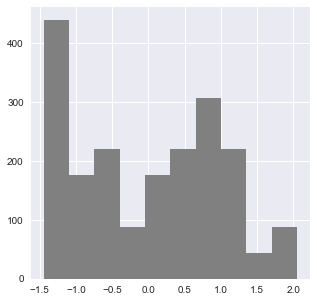

In [140]:
fig,ax = plt.subplots(figsize=(5,5),facecolor='w')
plt.xlabel = ('Minimum Hamming Distance')
plt.ylabel = "Number of Simulations"
plt.hist(originPopSz_transformed, color="grey", bins=10)
plt.show()
#plt.savefig('trial.png')

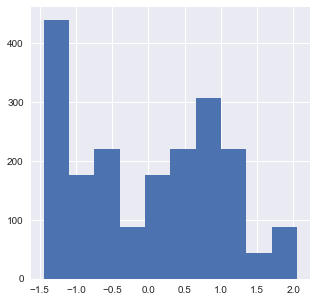

In [125]:
fig,ax = plt.subplots(figsize=(5,5),facecolor='w')
plt.xlabel = ('Minimum Hamming Distance')
plt.ylabel = "Number of Simulations"
plt.hist(destinPopSz_transformed)
plt.show()

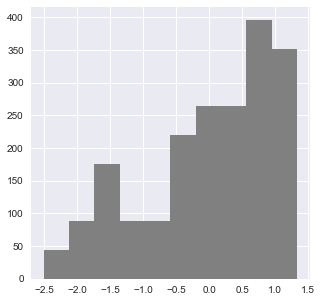

In [141]:
fig,ax = plt.subplots(figsize=(5,5),facecolor='w')
plt.xlabel = ('Minimum Hamming Distance')
plt.ylabel = "Number of Simulations"
plt.hist(originPropUrban_transformed, color="grey", bins=10)
plt.show()

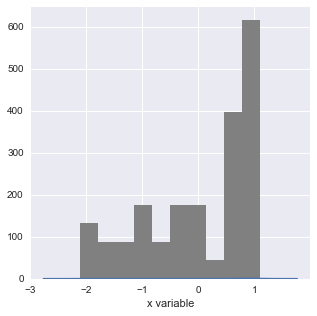

In [144]:
fig,ax = plt.subplots(figsize=(5,5),facecolor='w')
x = pd.Series(originSuitability_transformed, name="x variable")
ax = sb.distplot(x)

plt.xlabel = ('Minimum Hamming Distance')
plt.ylabel = "Number of Simulations"
plt.hist(originSuitability_transformed, color="grey", bins=10)
plt.show()

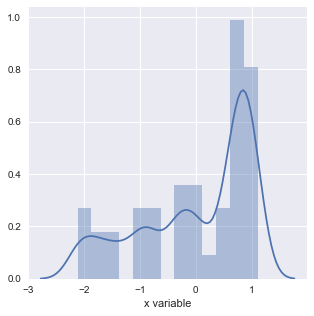

In [143]:
#sb.distplot(north_south_transformed)
#sb.distplot(originSuitability_transformed)
fig,ax = plt.subplots(figsize=(5,5),facecolor='w')

import pandas as pd
x = pd.Series(originSuitability_transformed, name="x variable")
ax = sns.distplot(x)

In [19]:
print predictor_dict[600]['country_pair']
print predictor_dict[600]['pax_volume']

('haiti', 'suriname')
6670.0
